# **Core Stock Data Preprocessing Notebook**
## In this notebook we will preprocess our core stock data, looking for potential outliers in order to make out data more efficient as well as then moving on to scaling our data for normalization purposes.  We will then create lag windows and custom features for our core stock data, and make sure there are no missing values.  If there are we will fill and impute as needed and save to the existing csv file to prepare for the next step in our Linear Regression Modeling.

#### Let's start by bringing in the libraries and logic necessary for reading in our file.

In [1]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy import stats



#### Now let's read in our data that we need for this notebook.

In [2]:
# Now let's access the main core_stock_data.csv file
csv_path = os.path.join(project_root, 'data', 'core_stock_data.csv')
core_stock_data = pd.read_csv(csv_path, parse_dates=['Date'], index_col= 'Date')
core_stock_data.head()
core_stock_data.shape

(13650, 26)

#### The first step I want to undertake is handling and imputing any missing features.  I want to do this first so that when we create our lag windows and resulting custom features the new values will be calculated properly, and it will be easier to address our resulting outliers.  We will look at the same process that we used for our core stock data, a combination of ffill, bfill and linear interpolation for max efficiency of our missing values.

In [3]:
def fill_missing_vals(df):
    df.ffill(inplace = True)
    df.bfill(inplace = True)
    df.interpolate(method = 'linear', inplace = True)
    
    return df

core_stock_data = core_stock_data.copy()

for col in core_stock_data.columns:
    if core_stock_data[col].isnull().any():
        core_stock_data.loc[:, col] = fill_missing_vals(core_stock_data[[col]]).squeeze()



print(core_stock_data.isna().sum())

Close_core          0
Volume_core         0
Open_core           0
High_core           0
Low_core            0
SMA_core            0
EMA_core            0
RSI_core            0
BBM_core            0
BBU_core            0
BBL_core            0
MACD_core           0
MACD_Signal_core    0
MACD_Hist_core      0
ADX_14_core         0
CCI_20_core         0
ATR_14_core         0
Stoch_K_core        0
Stoch_D_core        0
Momentum_1_core     0
Momentum_3_core     0
Momentum_7_core     0
Momentum_30_core    0
Momentum_50_core    0
OBV_core            0
Ticker              0
dtype: int64


#### Looks great, now let's create the lag windows and custom features for our core stocks.

In [4]:
# We will need to create a temp variable since we are making so many custom features, it will otherwise create a PerformanceWarning since when we execute the cell on our main df its too much at once.
# By storing all the custom features to a temp variable and then concatenating them in a separate step it takes the pressure off in the execute phase.
new_temp_columns = pd.DataFrame(index = core_stock_data.index)

# Now let's create a variable to house our features we want to create lag features for.
features_to_lag = ['Open_core', 'High_core', 'Low_core', 'Volume_core','Close_core', 'EMA_core', 'SMA_core', 'RSI_core', 'BBM_core', 'BBL_core', 'BBU_core', 'MACD_core', 'MACD_Signal_core', 'MACD_Hist_core', 'ADX_14_core', 'CCI_20_core', 'ATR_14_core', 'Stoch_K_core', 'Stoch_D_core', 'Momentum_1_core', 'Momentum_3_core', 'Momentum_7_core', 'Momentum_30_core', 'Momentum_50_core', 'OBV_core']

# Now we apply the lag windows with a small 3-day window size.
for feature in features_to_lag:
    for lag in range(1,4):
        new_temp_columns[f'{feature}_Lag_{lag}'] = core_stock_data[feature].shift(lag)

# Great, now from these new lag-based features let's expand on it further by creating some custom features using our existing ones.
new_temp_columns['Close_Lag_Avg_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].std(axis = 1)

new_temp_columns['Open_Lag_Avg_1_3_core'] = new_temp_columns[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].mean(axis = 1)
new_temp_columns['Open_Lag_Std_1_3_core'] = new_temp_columns[['Open_core_Lag_1', 'Open_core_Lag_2', 'Open_core_Lag_3']].std(axis = 1)

new_temp_columns['High_Lag_Avg_1_3_core'] = new_temp_columns[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].mean(axis = 1)
new_temp_columns['High_Lag_Std_1_3_core'] = new_temp_columns[['High_core_Lag_1', 'High_core_Lag_2', 'High_core_Lag_3']].std(axis = 1)

new_temp_columns['Low_Lag_Avg_1_3_core'] = new_temp_columns[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].mean(axis = 1)
new_temp_columns['Low_Lag_Std_1_3_core'] = new_temp_columns[['Low_core_Lag_1', 'Low_core_Lag_2', 'Low_core_Lag_3']].std(axis = 1)

new_temp_columns['Volume_Lag_Avg_1_3_core'] = new_temp_columns[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].mean(axis = 1)
new_temp_columns['Volume_Lag_Std_1_3_core'] = new_temp_columns[['Volume_core_Lag_1', 'Volume_core_Lag_2', 'Volume_core_Lag_3']].std(axis = 1)

new_temp_columns['EMA_Lag_Avg_1_3_core'] = new_temp_columns[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].mean(axis = 1)
new_temp_columns['EMA_Lag_Std_1_3_core'] = new_temp_columns[['EMA_core_Lag_1', 'EMA_core_Lag_2', 'EMA_core_Lag_3']].std(axis = 1)

new_temp_columns['SMA_Lag_Avg_1_3_core'] = new_temp_columns[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].mean(axis = 1)
new_temp_columns['SMA_Lag_Std_1_3_core'] = new_temp_columns[['SMA_core_Lag_1', 'SMA_core_Lag_2', 'SMA_core_Lag_3']].std(axis = 1)

new_temp_columns['RSI_Lag_Avg_1_3_core'] = new_temp_columns[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].mean(axis = 1)
new_temp_columns['RSI_Lag_Std_1_3_core'] = new_temp_columns[['RSI_core_Lag_1', 'RSI_core_Lag_2', 'RSI_core_Lag_3']].std(axis = 1)

new_temp_columns['BBM_Lag_Avg_1_3_core'] = new_temp_columns[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBM_Lag_Std_1_3_core'] = new_temp_columns[['BBM_core_Lag_1', 'BBM_core_Lag_2', 'BBM_core_Lag_3']].std(axis = 1)

new_temp_columns['BBU_Lag_Avg_1_3_core'] = new_temp_columns[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBU_Lag_Std_1_3_core'] = new_temp_columns[['BBU_core_Lag_1', 'BBU_core_Lag_2', 'BBU_core_Lag_3']].std(axis = 1)

new_temp_columns['BBL_Lag_Avg_1_3_core'] = new_temp_columns[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].mean(axis = 1)
new_temp_columns['BBL_Lag_Std_1_3_core'] = new_temp_columns[['BBL_core_Lag_1', 'BBL_core_Lag_2', 'BBL_core_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_K_Lag_Avg_1_3_core'] = new_temp_columns[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_K_Lag_Std_1_3_core'] = new_temp_columns[['Stoch_K_core_Lag_1', 'Stoch_K_core_Lag_2', 'Stoch_K_core_Lag_3']].std(axis = 1)

new_temp_columns['Stoch_D_Lag_Avg_1_3_core'] = new_temp_columns[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].mean(axis = 1)
new_temp_columns['Stoch_D_Lag_Std_1_3_core'] = new_temp_columns[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Lag_Avg_1_3_core'] = new_temp_columns[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Lag_Std_1_3_core'] = new_temp_columns[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Signal_Lag_Avg_1_3_core'] = new_temp_columns[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Signal_Lag_Std_1_3_core'] = new_temp_columns[['MACD_Signal_core_Lag_1', 'MACD_Signal_core_Lag_2', 'MACD_Signal_core_Lag_3']].std(axis = 1)

new_temp_columns['MACD_Hist_Avg_1_3_core'] = new_temp_columns[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].mean(axis = 1)
new_temp_columns['MACD_Hist_Lag_Std_1_3_core'] = new_temp_columns[['MACD_Hist_core_Lag_1', 'MACD_Hist_core_Lag_2', 'MACD_Hist_core_Lag_3']].std(axis = 1)

new_temp_columns['ADX_14_Lag_Avg_1_3_core'] = new_temp_columns[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].mean(axis = 1)
new_temp_columns['ADX_14_Lag_Std_1_3_core'] = new_temp_columns[['ADX_14_core_Lag_1', 'ADX_14_core_Lag_2', 'ADX_14_core_Lag_3']].std(axis = 1)

new_temp_columns['CCI_20_Lag_Avg_1_3_core'] = new_temp_columns[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].mean(axis = 1)
new_temp_columns['CCI_20_Lag_Std_1_3_core'] = new_temp_columns[['CCI_20_core_Lag_1', 'CCI_20_core_Lag_2', 'CCI_20_core_Lag_3']].std(axis = 1)

new_temp_columns['ATR_14_Lag_Avg_1_3_core'] = new_temp_columns[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].mean(axis = 1)
new_temp_columns['ATR_14_Lag_Std_1_3_core'] = new_temp_columns[['ATR_14_core_Lag_1', 'ATR_14_core_Lag_2', 'ATR_14_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_1_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_1_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_1_core_Lag_1', 'Momentum_1_core_Lag_2', 'Momentum_1_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_3_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_3_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_3_core_Lag_1', 'Momentum_3_core_Lag_2', 'Momentum_3_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_7_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_7_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_7_core_Lag_1', 'Momentum_7_core_Lag_2', 'Momentum_7_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_30_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_30_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_30_core_Lag_1', 'Momentum_30_core_Lag_2', 'Momentum_30_core_Lag_3']].std(axis = 1)

new_temp_columns['Momentum_50_Lag_Avg_1_3_core'] = new_temp_columns[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].mean(axis = 1)
new_temp_columns['Momentum_50_Lag_Std_1_3_core'] = new_temp_columns[['Momentum_50_core_Lag_1', 'Momentum_50_core_Lag_2', 'Momentum_50_core_Lag_3']].std(axis = 1)

new_temp_columns['OBV_Lag_Avg_1_3_core'] = new_temp_columns[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].mean(axis = 1)
new_temp_columns['OBV_Lag_Std_1_3_core'] = new_temp_columns[['OBV_core_Lag_1', 'OBV_core_Lag_2', 'OBV_core_Lag_3']].std(axis = 1)

new_temp_columns['Close_Lag_Avg_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].mean(axis = 1)
new_temp_columns['Close_Lag_Std_1_3_core'] = new_temp_columns[['Close_core_Lag_1', 'Close_core_Lag_2', 'Close_core_Lag_3']].std(axis = 1)

new_temp_columns['Diff_Close_EMA_core'] = core_stock_data['Close_core'] - core_stock_data['EMA_core']
new_temp_columns['Ratio_Close_EMA_core'] = core_stock_data['Close_core'] / core_stock_data['EMA_core']

# Now we can concatenate onto our original core_stock_data.
core_stock_data = pd.concat([core_stock_data, new_temp_columns], axis = 1)

print(core_stock_data.head())

#print(core_stock_data.head(10))
print(core_stock_data.isnull().sum())

            Close_core  Volume_core  Open_core  High_core   Low_core  \
Date                                                                   
2019-03-14   45.932499     94318000  45.974998  46.025002  45.639999   
2019-03-15   46.529999    156171600  46.212502  46.832500  45.935001   
2019-03-18   47.005001    104879200  46.450001  47.097500  46.447498   
2019-03-19   46.632500    126585600  47.087502  47.247501  46.480000   
2019-03-20   47.040001    124140800  46.557499  47.372501  46.182499   

            SMA_core   EMA_core   RSI_core  BBM_core   BBU_core  ...  \
Date                                                             ...   
2019-03-14  41.35925  42.219051  75.741602  41.35925  46.695085  ...   
2019-03-15  41.50025  42.388107  76.985910  41.50025  47.003365  ...   
2019-03-18  41.72940  42.569162  78.724282  41.72940  47.174667  ...   
2019-03-19  41.92075  42.728509  73.527018  41.92075  47.369412  ...   
2019-03-20  42.12190  42.897587  80.396901  42.12190  47.569044

C:\Users\ryanm\AppData\Local\Temp\ipykernel_24016\1656009815.py:51: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['Stoch_D_Lag_Std_1_3_core'] = new_temp_columns[['Stoch_D_core_Lag_1', 'Stoch_D_core_Lag_2', 'Stoch_D_core_Lag_3']].std(axis = 1)
C:\Users\ryanm\AppData\Local\Temp\ipykernel_24016\1656009815.py:53: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  new_temp_columns['MACD_Lag_Avg_1_3_core'] = new_temp_columns[['MACD_core_Lag_1', 'MACD_core_Lag_2', 'MACD_core_Lag_3']].mean(axis = 1)
C:\Users\ryanm\AppData\Lo

#### It looks like through the creation of all of our new features there are just a few missing values that slipped through.  Let's re-run our imputation logic to take care of them.  Also since I see 0s in our .head() printout, we will address those in our function below as leaving those will cause issues down the road with our outlier calculations.

In [5]:

def fill_missing_vals(df):
    # Ensure we're only applying the logic to numeric columns
    numeric_cols = df.select_dtypes(include=[np.number])
    
    # Replace any 0s or negative values with extremely small positive integers
    numeric_cols = numeric_cols.apply(lambda x: np.where(x <= 0, 1e-10, x))
    
    # Impute missing values with the following methodologies    
    numeric_cols.ffill(inplace=True)
    numeric_cols.bfill(inplace=True)
    numeric_cols.interpolate(method='linear', inplace=True)
    
    # Update the original dataframe with the modified numeric columns
    df[numeric_cols.columns] = numeric_cols
    
    return df

core_stock_data = core_stock_data.copy()

# Apply fill_missing_vals only to numeric columns with missing values
core_stock_data = fill_missing_vals(core_stock_data)

print("Missing values handled:")
print(core_stock_data.isna().sum())

# We will also put in a check for extremely large values as we are seeing warnings for those below
def replace_large_values(df, threshold=1e9):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Apply logic only to numeric columns
    numeric_cols = df.select_dtypes(include=[np.number])
    
    # Debug print statement to see what and how many values exceed our given threshold.
    print("Values exceeding the threshold before replacement:")
    for col in numeric_cols.columns:
        large_vals = numeric_cols[numeric_cols[col] > threshold]
        if not large_vals.empty:
            print(f"Column '{col}' has values larger than the threshold:")
            print(large_vals[col])
    
    # Replace large values with NaN
    numeric_cols = numeric_cols.applymap(lambda x: np.nan if x > 1e10 else x)
    
    # Apply the fill_missing_vals logic to impute the modified numeric columns
    numeric_cols = fill_missing_vals(numeric_cols)
    
    # Update the original dataframe with the modified numeric columns
    df[numeric_cols.columns] = numeric_cols
    
    return df

threshold_value = 1e9
core_stock_data = replace_large_values(core_stock_data, threshold=threshold_value)

# Calculate the max and min values only for numeric columns
numeric_cols = core_stock_data.select_dtypes(include = [np.number])

print("Max value after replacement", numeric_cols.max().max())
print("Min value after replacement:", numeric_cols.min().min())

Missing values handled:
Close_core                      0
Volume_core                     0
Open_core                       0
High_core                       0
Low_core                        0
                               ..
Momentum_50_Lag_Std_1_3_core    0
OBV_Lag_Avg_1_3_core            0
OBV_Lag_Std_1_3_core            0
Diff_Close_EMA_core             0
Ratio_Close_EMA_core            0
Length: 153, dtype: int64
Values exceeding the threshold before replacement:
Column 'Volume_core' has values larger than the threshold:
Date
2019-05-17    1.022068e+09
2019-08-16    1.007960e+09
2019-11-15    1.053628e+09
2020-02-14    1.041924e+09
2020-02-25    1.055496e+09
2020-02-28    1.133252e+09
2020-03-24    1.101644e+09
2020-05-22    1.038764e+09
2020-05-27    1.175892e+09
2020-09-04    1.463684e+09
2020-09-14    1.201744e+09
2021-11-04    1.153631e+09
2022-09-01    1.178865e+09
2023-02-23    1.117995e+09
2023-05-25    1.543911e+09
2023-05-31    1.002580e+09
2023-08-24    1.156044e+09
20

C:\Users\ryanm\AppData\Local\Temp\ipykernel_24016\1413338541.py:42: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  numeric_cols = numeric_cols.applymap(lambda x: np.nan if x > 1e10 else x)


Max value after replacement 9999180000.0
Min value after replacement: 3.23815048849004e-17


#### Great, now let's look into viewing and handling outliers.  We will first see the appearance of outliers using z_score with a standard std of 3, and then looking at the column feature spread.

#### First though we will create a save point and a separate csv of our unscaled core stock data, as we will need this in an upcoming notebook.

In [6]:
core_stock_data.to_csv(os.path.join(project_root, 'data', 'core_stock_unscaled.csv'), index = True)

In [7]:
numeric_cols = core_stock_data.select_dtypes(include = [np.number])
z_scores = np.abs(stats.zscore(numeric_cols))
threshold = 3 # Common threshold starting std modifier

outliers = (z_scores > threshold)

print(outliers.sum(axis = 0))


Close_core                       29
Volume_core                     415
Open_core                        27
High_core                        26
Low_core                         27
                               ... 
Momentum_50_Lag_Std_1_3_core    245
OBV_Lag_Avg_1_3_core              0
OBV_Lag_Std_1_3_core            158
Diff_Close_EMA_core             263
Ratio_Close_EMA_core            229
Length: 152, dtype: int64


#### Our Volume_sec feature in particular has an alarming amount of outliers, and as we know Volume is used to calculate a lot of our other other custom features.  We will need to normalize the Volume feature so we can figure out what's going on.  Let's take a closer look with a plot.

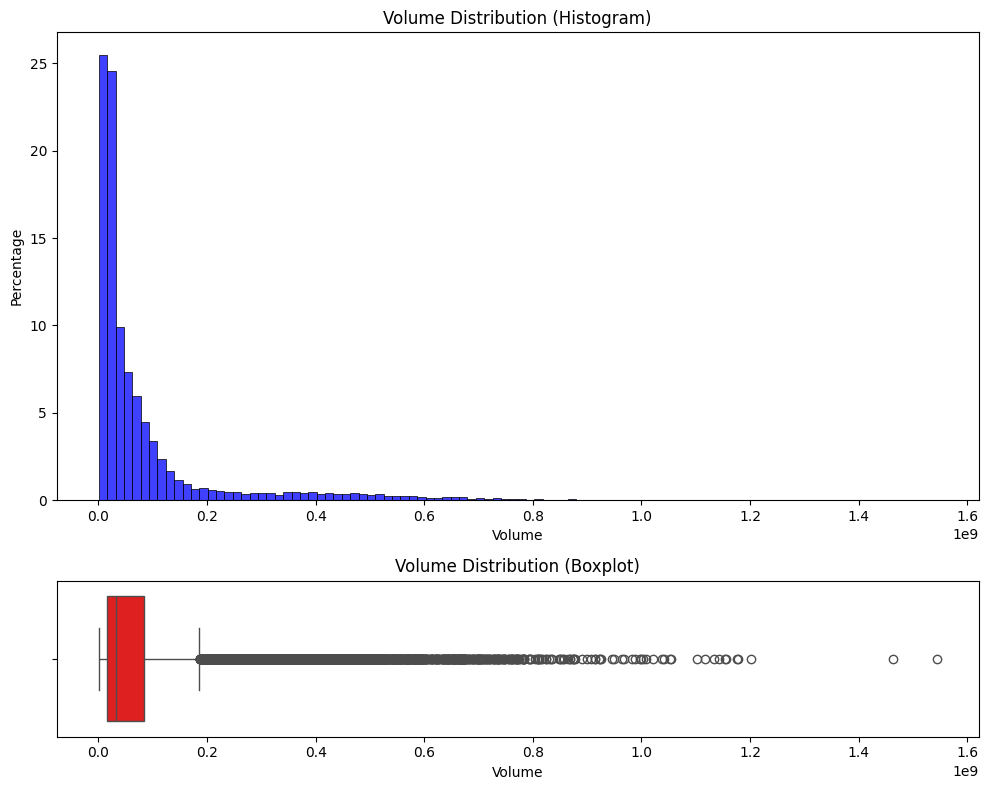

In [8]:
fig, ax = plt.subplots(2,1, figsize = (10, 8), gridspec_kw = {'height_ratios' : [3,1]})

sns.histplot(core_stock_data['Volume_core'], bins = 100, kde = False, ax = ax[0], stat = 'percent', color = 'b')
ax[0].set_title('Volume Distribution (Histogram)')
ax[0].set_xlabel('Volume')
ax[0].set_ylabel('Percentage')

sns.boxplot(x = core_stock_data['Volume_core'], ax = ax[1], color = 'r', whis = 1.5)
ax[1].set_title('Volume Distribution (Boxplot)')
ax[1].set_xlabel('Volume')


plt.tight_layout()
plt.show()



#### So the plot above tells us a few things about our Volume data.  It shows in the top portion that 25% of the Volume values have a very low trading volume.  As you move forward past that point the trading volumes increase but so do the number of observations for those points.  The boxplot below echoes this as well.  What this represents is that the large outliers (the smaller bars in the histogram that make up our outlier volume) could represent significant events or sudden spikes in activity.  As such further performance on our outliers is warranted so we can establish normal distribution.

In [9]:
def volume_log_transform(core_stock_data):
    core_stock_data['Volume_core'] = np.log1p(core_stock_data['Volume_core'])
    return core_stock_data

core_stock_data = volume_log_transform(core_stock_data)

#### Now we will replot the Volume feature to see how it looks after the log transform.

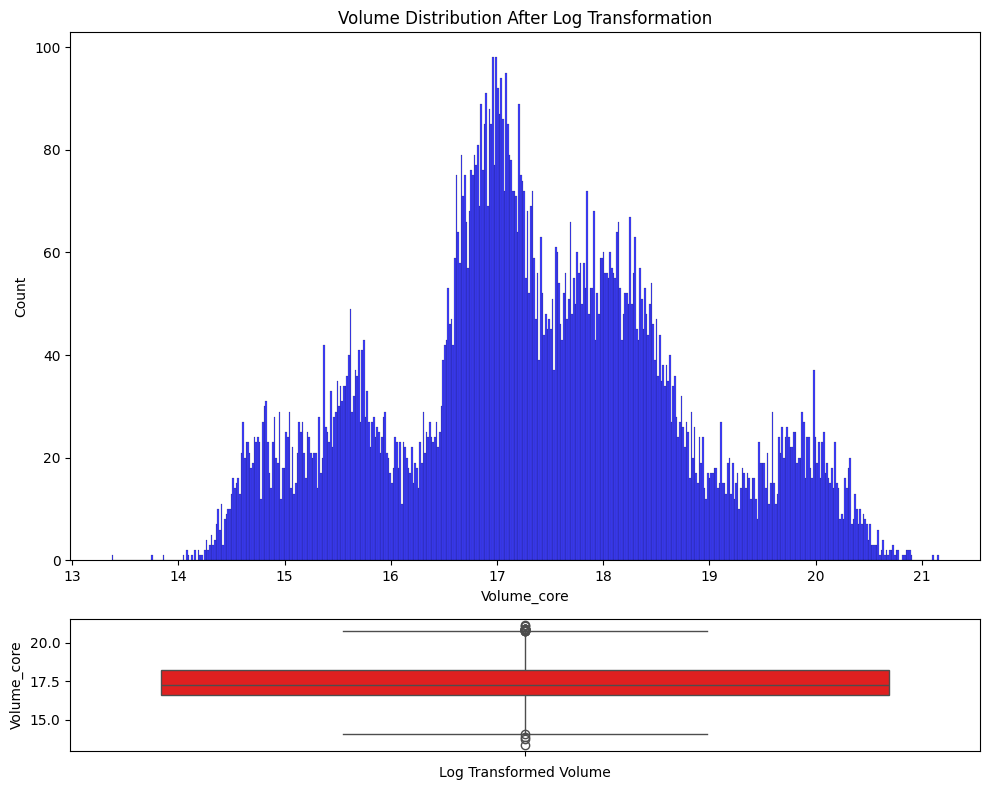

In [10]:
fig, (ax_hist, ax_box) = plt.subplots(
    2,
    figsize = (10,8),
    gridspec_kw = {'height_ratios' : [4,1]},
    )

sns.histplot(core_stock_data['Volume_core'], bins = 500, ax = ax_hist, color = 'blue')
ax_hist.set_title('Volume Distribution After Log Transformation')
ax_hist.set_ylabel('Count')

sns.boxplot(core_stock_data['Volume_core'], ax = ax_box, color = 'red')
ax_box.set_xlabel('Log Transformed Volume')

plt.tight_layout()
plt.show()

#### This is much better, there are noticeably fewer outliers shown in the top part of the plot and you can see the bell curve shape for our Volume feature.

#### Let's apply the log transform to the rest of our features, being careful not to duplicate any of our outlier detection activity.

In [11]:

def volume_log_transform_rest(core_stock_data):
    # Get the rest of the features, removing Volume_core from the calculation as its already had the log_transform done on it.
    numeric_cols = core_stock_data.select_dtypes(include = [np.number]).columns.tolist()
    numeric_cols.remove('Volume_core')
    
    # Apply log transform on rest of features
    core_stock_data[numeric_cols] = np.log1p(core_stock_data[numeric_cols])
    
    return core_stock_data

core_stock_data = volume_log_transform_rest(core_stock_data)


# Check the transformed data
print(core_stock_data.head())


            Close_core  Volume_core  Open_core  High_core  Low_core  SMA_core  \
Date                                                                            
2019-03-14    3.848710    18.362183   3.849616   3.850679  3.842459  3.746187   
2019-03-15    3.861361    18.866466   3.854659   3.867705  3.848764  3.749510   
2019-03-18    3.871305    18.468320   3.859677   3.873230  3.859624  3.754887   
2019-03-19    3.863515    18.656429   3.873022   3.876344  3.860309  3.759355   
2019-03-20    3.872034    18.636927   3.861939   3.878931  3.854023  3.764031   

            EMA_core  RSI_core  BBM_core  BBU_core  ...  \
Date                                                ...   
2019-03-14  3.766281  4.340444  3.746187  3.864828  ...   
2019-03-15  3.770185  4.356528  3.749510  3.871271  ...   
2019-03-18  3.774350  4.378574  3.754887  3.874833  ...   
2019-03-19  3.778000  4.311162  3.759355  3.878868  ...   
2019-03-20  3.781859  4.399337  3.764031  3.882986  ...   

            Moment

#### Output looks good so far, let's look at a quick distribution plot before moving on.

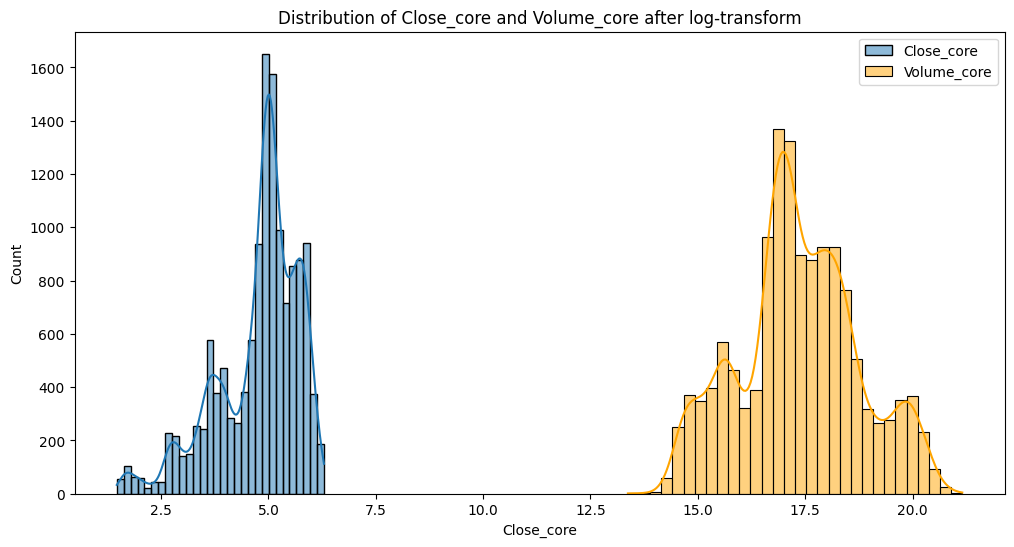

In [12]:
plt.figure(figsize=(12, 6))

# Plotting the distribution of some key columns
sns.histplot(core_stock_data['Close_core'], kde=True, bins=30, label='Close_core')
sns.histplot(core_stock_data['Volume_core'], kde=True, bins=30, label='Volume_core', color='orange')
plt.legend()
plt.title('Distribution of Close_core and Volume_core after log-transform')
plt.show()

#### Volum_core looks great, a very nice normal distribution and outcome.

# Looks good, now we can move on to scaling our new dataframe.

In [13]:
# We will need to temporarily drop the Ticker column as it is a float value.  We will create a variable for it now, and use it later to bring it back when needed.
tickers = core_stock_data['Ticker'].values
core_stock_data = core_stock_data.drop(columns = ['Ticker'])

# Initiate the scaler and transform the data.
scaler = StandardScaler()
scaled_data = scaler.fit_transform(core_stock_data)
core_stock_scaled = pd.DataFrame(scaled_data, index = core_stock_data.index, columns = core_stock_data.columns)
print(core_stock_scaled.head())

            Close_core  Volume_core  Open_core  High_core  Low_core  SMA_core  \
Date                                                                            
2019-03-14   -0.954785     0.728372  -0.953290  -0.966273 -0.946685 -1.036480   
2019-03-15   -0.941600     1.089768  -0.948034  -0.948515 -0.940119 -1.033031   
2019-03-18   -0.931235     0.804435  -0.942805  -0.942752 -0.928810 -1.027449   
2019-03-19   -0.939354     0.939245  -0.928897  -0.939505 -0.928097 -1.022811   
2019-03-20   -0.930476     0.925268  -0.940447  -0.936806 -0.934642 -1.017958   

            EMA_core  RSI_core  BBM_core  BBU_core  ...  \
Date                                                ...   
2019-03-14 -1.018443  1.079385 -1.036480 -1.032897  ...   
2019-03-15 -1.014385  1.123886 -1.033031 -1.026146  ...   
2019-03-18 -1.010056  1.184881 -1.027449 -1.022413  ...   
2019-03-19 -1.006262  0.998369 -1.022811 -1.018185  ...   
2019-03-20 -1.002250  1.242326 -1.017958 -1.013869  ...   

            Moment

#### This looks good, let's save it so we can use later on in our baseline modeling notebook.

In [14]:
# Need to add back in our Ticker column first
core_stock_scaled['Ticker'] = tickers

core_stock_scaled.to_csv(os.path.join(project_root, 'data', 'core_stock_preprocessed.csv'), index = True)
